## EXOD Detector MOS

Import

In [1]:
import sys
import os
import time
import shutil
from functools import partial

# Third-party imports

from math import *
from multiprocessing import Pool
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import argparse
import matplotlib
matplotlib.use("Pdf")
from matplotlib import colors, image, transforms, gridspec
import matplotlib.pyplot as plt
from pylab import figure, cm

# Internal imports

from fits_extractor import *
from variability_utils import *
import file_names as FileNames
from file_utils import *
from renderer import *

Arguments

In [25]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'PN_clean.fits'
img  = path + 'PN_image.fits'
gti  = path + 'PN_gti.fits'
out  = path + '8_200_5_1.0_PN'
obs  = '0112570101'
bs   = 5
dl   = 8
tw   = 200
gtr  = 1.0
mta  = 8
inst = 'PN'
ol   = path + 'log.txt'
ccdnb = 12

In [6]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'M1_clean.fits'
img  = path + 'M1_image.fits'
gti  = path + 'M1_gti.fits'
out  = path + '8_500_5_1.0_M1'
obs  = '0112570101'
bs   = 5
dl   = 8
tw   = 500
gtr  = 1.0
mta  = 8
inst = 'M1'
ol   = path + 'log.txt'
ccdnb = 7

In [39]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'M2_clean.fits'
img  = path + 'M2_image.fits'
gti  = path + 'M2_gti.fits'
out  = path + '8_500_5_1.0_M2'
obs  = '0112570101'
bs   = 5
dl   = 8
tw   = 500
gtr  = 1.0
mta  = 8
inst = 'M2'
ol   = path + 'log.txt'
ccdnb = 7

Preliminaries

In [40]:
# Opening the output fileslog_f, var_f, reg_f = open_files(out)
log_f, var_f, reg_f = open_files(out)
sys.stdout = Tee(sys.stdout, log_f)

# Recovering the EVENTS list
data, header = extraction_photons(evts)

# Recovering the GTI list
gti_list = extraction_deleted_periods(gti)

# Computation of t0 and tf
t0_observation = min([evt['TIME'] for ccd in data for evt in ccd])
tf_observation = max([evt['TIME'] for ccd in data for evt in ccd])

In [41]:
submode = header['SUBMODE']

In [42]:
submode

'PrimeFullWindow'

#### Computing variability

In [43]:
v_matrix = []
var_calc_partial = partial(variability_computation, gti_list, tw, gtr, t0_observation, tf_observation, inst)

with Pool(mta) as p:
    v_matrix = p.map(var_calc_partial, data)

In [44]:
if inst == 'PN' :
    data_v = PN_config(v_matrix)
elif inst == 'M1' :
    data_v = M1_config(v_matrix)
elif inst == 'M2' :
    data_v = M2_config(v_matrix)

data_v = np.array(data_v)

In [31]:
#PN

if submode == 'PrimeLargeWindow' :
    data_vm = data_v[:,100:300]
if submode == 'PrimeSmallWindow' :
    data_vm = data_v[128:192,200:264]
else :
    data_vm = data_v

In [45]:
#MOS

data_vm = data_v

In [46]:
np.shape(data_vm)

(1800, 1800)

#### Geometrical transformations

In [47]:
# Header information
angle = header['PA_PNT']

xproj = [float(header['TDMIN6']), float(header['TDMAX6'])] # projected x limits
yproj = [float(header['TDMIN7']), float(header['TDMAX7'])] # projected y limits
xlims = [float(header['TLMIN6']), float(header['TLMAX6'])] # legal x limits
ylims = [float(header['TLMIN7']), float(header['TLMAX7'])] # legal y limits

# scaling factor
sx = 648 / (xlims[1] - xlims[0])
sy = 648 / (ylims[1] - ylims[0])

In [35]:
# PN

# pads (padding)
padX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
padY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
# shape (resizing)
pixX = 648 - (padX[0] + padX[1])
pixY = 648 - (padY[0] +padY[1])

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = True))
## Resizing
dataT = skimage.transform.resize(dataR, (pixY, pixX), mode='constant', cval=0.0) # xy reversed
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [48]:
#MOS

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
    
padX = (int(interX[0]/(interX[0] + interX[1])*148), 148-int(interX[0]/(interX[0] + interX[1])*148))
padY = (int(interY[0]/(interY[0] + interY[1])*148), 148-int(interY[0]/(interY[0] + interY[1])*148))

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [21]:
#MOS1 test

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
    
padX = (int(interX[0]/(interX[0] + interX[1])*148)+int(np.cos(np.deg2rad(angle))*20), 148-int(interX[0]/(interX[0] + interX[1])*148)-int(np.cos(np.deg2rad(angle))*20))
padY = (int(interY[0]/(interY[0] + interY[1])*148)-int(np.sin(np.deg2rad(angle))*20), 148-int(interY[0]/(interY[0] + interY[1])*148)+int(np.sin(np.deg2rad(angle))*20))

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [49]:
angle

249.841567993164

In [50]:
interX

(81, 43)

In [51]:
padX

(96, 52)

In [52]:
np.cos(np.deg2rad(angle))

-0.34461723305076997

In [53]:
np.sin(np.deg2rad(angle))

-0.9387432890223137

#### Variable areas

In [54]:
v_matrix = np.array(v_matrix)
median = np.median(v_matrix)

In [55]:
median2 = np.median([v_matrix[ccd][i][j] for ccd in range(ccdnb) for i in range(len(v_matrix[ccd])) for j in range(len(v_matrix[ccd][i]))])

In [56]:
np.max(data_vm)

8.0

In [57]:
median2

0.0

In [58]:
if median < 0.75 :
    median = 0.75

In [59]:
variable_areas = []
variable_areas_detection_partial = partial(variable_areas_detection, median, bs, dl, inst)

with Pool(mta) as p:
    variable_areas = p.map(variable_areas_detection_partial, v_matrix)

In [60]:
variable_areas

[[{(33, 299),
   (33, 300),
   (33, 301),
   (33, 302),
   (33, 303),
   (34, 299),
   (34, 300),
   (34, 301),
   (34, 302),
   (34, 303),
   (35, 299),
   (35, 300),
   (35, 301),
   (35, 302),
   (35, 303),
   (36, 299),
   (36, 300),
   (36, 301),
   (36, 302),
   (36, 303),
   (37, 299),
   (37, 300),
   (37, 301),
   (37, 302),
   (37, 303)},
  {(93, 187),
   (93, 188),
   (93, 189),
   (93, 190),
   (93, 191),
   (94, 187),
   (94, 188),
   (94, 189),
   (94, 190),
   (94, 191),
   (95, 187),
   (95, 188),
   (95, 189),
   (95, 190),
   (95, 191),
   (96, 187),
   (96, 188),
   (96, 189),
   (96, 190),
   (96, 191),
   (97, 187),
   (97, 188),
   (97, 189),
   (97, 190),
   (97, 191)},
  {(101, 369),
   (101, 370),
   (101, 371),
   (101, 372),
   (101, 373),
   (102, 369),
   (102, 370),
   (102, 371),
   (102, 372),
   (102, 373),
   (103, 369),
   (103, 370),
   (103, 371),
   (103, 372),
   (103, 373),
   (104, 369),
   (104, 370),
   (104, 371),
   (104, 372),
   (104, 373)

#### Searching for sources

In [61]:
sources = []
cpt_source = 0

# Computing source position
for ccd in range(ccdnb) :
    for source in variable_areas[ccd] :
        center_x = round(sum([p[0] for p in source]) / len(source), 2)
        center_y = round(sum([p[1] for p in source]) / len(source), 2)

        r = round(sqrt( (max([abs(p[0] - center_x) for p in source]))**2 + (max([abs(p[1] - center_y) for p in source]))**2 ), 2)

        # Avoiding bad pixels
        if [inst, ccd, int(center_x)] not in [['PN',4,11], ['PN',4,12], ['PN',4,13], ['PN',5,12], ['PN',10,28]] :
            cpt_source += 1
            sources.append([cpt_source, inst, ccd+1, center_x, center_y, r])

In [62]:
source_table = Table(names=('ID', 'INST', 'CCDNR', 'RAWX', 'RAWY', 'RAWR', 'X', 'Y', 'SKYR', 'RA', 'DEC', 'R'), dtype=('i2', 'U25', 'i2', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))
for i in range(len(sources)) :
    
    # Getting Source class
    src = Source(sources[i])
    #src.sky_coord(path_out, img_file, log_file)
    
    # Adding source to table
    source_table.add_row([src.id_src, src.inst, src.ccd, src.rawx, src.rawy, src.rawr, src.x, src.y, src.skyr, src.ra, src.dec, src.r])

In [63]:
source_table

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,M2,1,35.0,301.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
2,M2,1,95.0,189.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
3,M2,1,103.0,371.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
4,M2,1,150.0,214.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
5,M2,1,241.0,86.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
6,M2,1,259.0,336.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
7,M2,1,344.0,263.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001
8,M2,1,352.5,264.0,3.91,nan,nan,250.24,nan,nan,12.512
9,M2,1,425.0,275.0,2.83,nan,nan,181.12,nan,nan,9.056000000000001


#### Writing FITS

In [65]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

##### WCS Transformation

In [66]:
# Opening variability file
hdulist = fits.open(file)

data   = hdulist[0].data
src    = hdulist[1].data
header = hdulist[0].header

hdulist.close()

# Obtaining the WCS transformation parameters

w = wcs.WCS(header)

w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
w.wcs.cdelt = [header['REFXCDLT']/15, header['REFYCDLT']]
w.wcs.crval = [header['REFXCRVL']/15, header['REFYCRVL']]
w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

# Image limit
dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [68]:
maximum_value = max([max(tmp) for tmp in data])

In [69]:
maximum_value

4.159576732897114

In [70]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.7140194444444466  41.2460277777778  
CRPIX : 25921.0  25921.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -9.259259259259267e-07  1.38888888888889e-05  
NAXIS : 648  648

<IPython.core.display.Javascript object>


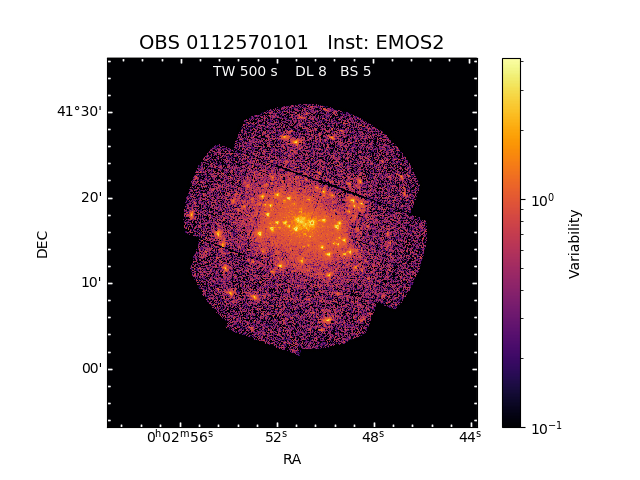

Text(0.5, 0.95, 'TW 500 s    DL 8   BS 5')

In [71]:
# Plotting the variability data
%matplotlib notebook
plt.subplot(111, projection=w)

im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

ax = plt.gca()
ax.set_facecolor('k')
cbar = plt.colorbar(im)

ra  = ax.coords[0]
dec = ax.coords[1]

ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ax.tick_params(axis='both', which='both', direction='in', color='w', width=1)

# Labels
plt.xlabel('RA', fontsize=10)
plt.ylabel('DEC', fontsize=10)
cbar.ax.set_ylabel('Variability', fontsize=10)

# Title
plt.title('OBS {0}   Inst: {1}'.format(header['OBS_ID'], header['INSTRUME']), fontsize=14)
plt.text(0.5, 0.95, "TW {0} s    DL {1}   BS {2}".format(tw, dl, bs), color='white', fontsize=10, horizontalalignment='center', transform = ax.transAxes)